In [2]:
%pip install matplotlib

  Using cached matplotlib-3.10.0-cp310-cp310-win_amd64.whl (8.0 MB)
  Using cached contourpy-1.3.1-cp310-cp310-win_amd64.whl (218 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl (71 kB)
     ---------------------------------------- 2.2/2.2 MB 23.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:17<00:00, 9.52MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


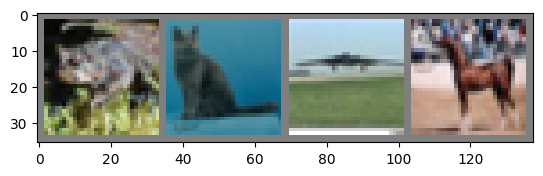

In [7]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


In [9]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/5], Step [2000/12500], Loss: 2.3202
Epoch [1/5], Step [4000/12500], Loss: 2.3092
Epoch [1/5], Step [6000/12500], Loss: 2.2587
Epoch [1/5], Step [8000/12500], Loss: 2.2466
Epoch [1/5], Step [10000/12500], Loss: 2.4942
Epoch [1/5], Step [12000/12500], Loss: 2.5302
Epoch [2/5], Step [2000/12500], Loss: 1.7605
Epoch [2/5], Step [4000/12500], Loss: 2.0872
Epoch [2/5], Step [6000/12500], Loss: 2.1332
Epoch [2/5], Step [8000/12500], Loss: 2.0195
Epoch [2/5], Step [10000/12500], Loss: 1.8792
Epoch [2/5], Step [12000/12500], Loss: 2.1087
Epoch [3/5], Step [2000/12500], Loss: 2.6913
Epoch [3/5], Step [4000/12500], Loss: 1.2259
Epoch [3/5], Step [6000/12500], Loss: 1.8069
Epoch [3/5], Step [8000/12500], Loss: 1.1583
Epoch [3/5], Step [10000/12500], Loss: 1.6151
Epoch [3/5], Step [12000/12500], Loss: 1.6671
Epoch [4/5], Step [2000/12500], Loss: 1.1811
Epoch [4/5], Step [4000/12500], Loss: 2.8781
Epoch [4/5], Step [6000/12500], Loss: 1.7145
Epoch [4/5], Step [8000/12500], Loss: 1.7823
Epoc

In [10]:
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Finished Training


In [11]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 49.08 %
Accuracy of plane: 45.8 %
Accuracy of car: 67.0 %
Accuracy of bird: 29.5 %
Accuracy of cat: 33.7 %
Accuracy of deer: 39.0 %
Accuracy of dog: 37.4 %
Accuracy of frog: 71.7 %
Accuracy of horse: 43.5 %
Accuracy of ship: 63.6 %
Accuracy of truck: 59.6 %
